In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter

# === Load .npy files ===
X_seq = np.load("X_seq.npy")  # shape: (N, 100, 1024)
y_seq = np.load("y_seq.npy")  # shape: (N,)

X_balanced = X_seq
y_balanced = y_seq

# === Split into train/test (stratified) ===
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# === Further split train into train/val (stratified) ===
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_train_np, y_train_np, test_size=0.1, stratify=y_train_np, random_state=42
)

# === Convert to PyTorch tensors ===
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.long)
X_val = torch.tensor(X_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.long)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.long)

# === Wrap in TensorDataset ===
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# === DataLoaders ===
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print("✅ Balanced DataLoaders ready:")
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


✅ Balanced DataLoaders ready:
Train: 7726 | Val: 859 | Test: 2147


In [2]:
from sklearn.utils.class_weight import compute_class_weight
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = np.unique(y_balanced)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_balanced)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [3]:
# === Check class presence ===
def count_unique_classes(dataset, name):
    labels = torch.tensor([label.item() for _, label in dataset])
    unique_classes = torch.unique(labels)
    print(f"{name} has {len(unique_classes)} unique classes: {sorted(unique_classes.tolist())}")

count_unique_classes(train_dataset, "Train")
count_unique_classes(val_dataset, "Validation")
count_unique_classes(test_dataset, "Test")

from collections import Counter

def print_class_distribution(dataset, name):
    labels = [label.item() for _, label in dataset]
    class_counts = Counter(labels)
    print(f"\n{name} class distribution:")
    for cls in sorted(class_counts):
        print(f"Class {cls}: {class_counts[cls]} samples")

print_class_distribution(train_dataset, "Train")
print_class_distribution(val_dataset, "Validation")
print_class_distribution(test_dataset, "Test")



Train has 57 unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
Validation has 57 unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
Test has 57 unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]

Train class distribution:
Class 0: 720 samples
Class 1: 29 samples
Class 2: 29 samples
Class 3: 29 samples
Class 4: 29 samples
Class 5: 337 samples
Class 6: 29 samples
Class 7: 29 samples
Class 8: 720 samples
Class 9: 29 samples
Class 10: 29 samples
C

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YAMNet1DCNN_Improved(nn.Module):
    def __init__(self, num_classes=57):
        super().__init__()
        self.conv1 = nn.Conv1d(1024, 512, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(512)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(512, 256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.65)  # Slightly higher for better regularization
        self.fc = nn.Linear(128, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, 100, 1024) → (B, 1024, 100)
        x = self.pool1(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool2(F.gelu(self.bn2(self.conv2(x))))
        x = F.gelu(self.bn3(self.conv3(x)))
        x = self.global_pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)


In [5]:
class YAMNetMLP(nn.Module):
    def __init__(self, num_classes=57):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):  # x: (B, 100, 1024)
        x = self.mlp(x)              # (B, 100, 128)
        x = x.mean(dim=1)            # (B, 128) – average over time steps
        return self.classifier(x)    # (B, num_classes)


In [7]:
class YAMNetLSTM(nn.Module):
    def __init__(self, hidden_size=128, num_layers=1, num_classes=57, dropout=0.1, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1024,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        output_size = hidden_size * 2 if bidirectional else hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(output_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):  # x: (B, 100, 1024)
        out, _ = self.lstm(x)        # out: (B, 100, H*2)
        out = out.mean(dim=1)        # mean pool over 100 frames → (B, H*2)
        return self.classifier(out)  # → (B, num_classes)

In [9]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, accuracy_score

def find_best_model_name(
    model_type_prefix, 
    model_class, 
    test_loader, 
    metric='test_acc',
    model_dir='.'    # New parameter for model directory
):
    """
    Finds the best model filename by specified metric in a given directory.

    Args:
        model_type_prefix (str): e.g., 'CNN', 'MLP', etc.
        model_class (nn.Module): Model class to instantiate and load.
        test_loader (DataLoader): Test data.
        metric (str): 'test_acc' or 'avg_class_acc'.
        model_dir (str): Directory containing model files.

    Returns:
        str: Best model filename (with path relative to model_dir).
    """
    model_files = [
        f for f in os.listdir(model_dir)
        if f.startswith(model_type_prefix) and f.endswith('.pt')
    ]
    if not model_files:
        raise FileNotFoundError(f"No model files found for prefix: {model_type_prefix} in {model_dir}")

    results = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for file in model_files:
        file_path = os.path.join(model_dir, file)
        model = model_class().to(device)
        model.load_state_dict(torch.load(file_path, map_location=device))
        model.eval()

        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        test_acc = accuracy_score(all_labels, all_preds) * 100
        cm = confusion_matrix(all_labels, all_preds)
        per_class_acc = np.diag(cm) / np.maximum(cm.sum(axis=1), 1)
        avg_class_acc = np.mean(per_class_acc) * 100

        results.append((file, test_acc, avg_class_acc))

    if metric == 'test_acc':
        best_model = max(results, key=lambda x: x[1])
    elif metric == 'avg_class_acc':
        best_model = max(results, key=lambda x: x[2])
    else:
        raise ValueError("metric must be 'test_acc' or 'avg_class_acc'")

    # Return full path to best model
    return os.path.join(model_dir, best_model[0])

def evaluate_model(
    model_name,
    model_class,
    model_path,
    test_loader,
    show_confusion_matrix=True,
    show_classification_report=True,
    show_per_class_accuracy=True,
    show_avg_per_class=True
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Overall Accuracy for {model_name}: {acc * 100:.2f}%")

    # === Classification Report ===
    if show_classification_report:
        print("\n📄 Classification Report:")
        print(classification_report(all_labels, all_preds, zero_division=0))

    # === Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    if show_confusion_matrix:
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix — {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    # === Per-Class Accuracy ===
    if show_per_class_accuracy:
        class_counts = cm.sum(axis=1)
        correct_counts = np.diag(cm)
        class_accuracy = correct_counts / np.maximum(class_counts, 1)

        plt.figure(figsize=(14, 6))
        plt.bar(range(len(class_accuracy)), class_accuracy)
        plt.xticks(ticks=range(len(class_accuracy)), labels=range(len(class_accuracy)), rotation=90)
        plt.ylim(0, 1.05)
        plt.ylabel("Accuracy")
        plt.title(f"Per-Class Accuracy — {model_name}")
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

        print("\n📊 Per-Class Accuracy:")
        for i, acc in enumerate(class_accuracy):
            print(f"Class {i:<2}: {acc * 100:.2f}%")

        if show_avg_per_class:
            avg_class_acc = np.mean(class_accuracy)
            print(f"\n📈 Average Per-Class Accuracy: {avg_class_acc * 100:.2f}%")


In [10]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

def get_high_accuracy_classes_from_model(
    model_name,
    model_class,
    model_path,
    test_loader,
    threshold=85.0,
    save_path="high_accuracy_classes.json"
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    class_counts = cm.sum(axis=1)
    correct_counts = np.diag(cm)
    class_accuracy = 100 * correct_counts / np.maximum(class_counts, 1)

    high_acc_classes = [i for i, acc in enumerate(class_accuracy) if acc >= threshold]

    print(f"\n✅ Classes with ≥{threshold:.0f}% accuracy in {model_name}: {high_acc_classes}")

    # Save result to JSON
    import json
    try:
        with open(save_path, "r") as f:
            existing = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        existing = {}

    existing[model_name] = high_acc_classes

    with open(save_path, "w") as f:
        json.dump(existing, f, indent=2)

    return high_acc_classes

def get_class_accuracies(
    model_name,
    model_class,
    model_path,
    test_loader
):
    import torch
    import numpy as np
    from sklearn.metrics import confusion_matrix

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=range(57))
    correct = np.diag(cm)
    total = cm.sum(axis=1)
    per_class_acc = 100 * correct / np.maximum(total, 1)

    return model_name, per_class_acc

def plot_combined_class_accuracy(acc_dict):
    classes = list(range(57))
    model_names = list(acc_dict.keys())
    width = 0.25

    plt.figure(figsize=(18, 6))
    for i, model in enumerate(model_names):
        acc = acc_dict[model]
        plt.bar(
            np.arange(len(classes)) + i * width,
            acc,
            width=width,
            label=model
        )

    plt.xticks(np.arange(len(classes)) + width, classes, rotation=90)
    plt.ylim(0, 105)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Class Index")
    plt.title("Per-Class Accuracy Comparison")
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

def get_strongest_model_per_class(acc_dict, save_path="models/SavedData/strongest_deep_model_per_class.json"):
    result = {}

    for i in range(57):  # For each class
        # Gather all model accuracies for this class
        model_scores = {model: round(accs[i], 2) for model, accs in acc_dict.items()}
        sorted_models = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)

        best_model, best_acc = sorted_models[0]
        second_acc = sorted_models[1][1] if len(sorted_models) > 1 else 0.0

        # Prefer CNN in case of tie
        if round(best_acc - second_acc, 2) == 0.0 and best_model != "CNN":
            for model, acc in sorted_models:
                if model == "CNN" and round(acc, 2) == round(best_acc, 2):
                    best_model = "CNN"
                    break

        diff = round(best_acc - second_acc, 2)

        result[str(i)] = {
            "best": best_model,
            "diff": diff,
            "accuracies": model_scores
        }

    # Save to JSON
    import json
    with open(save_path, "w") as f:
        json.dump(result, f, indent=2)

    return result

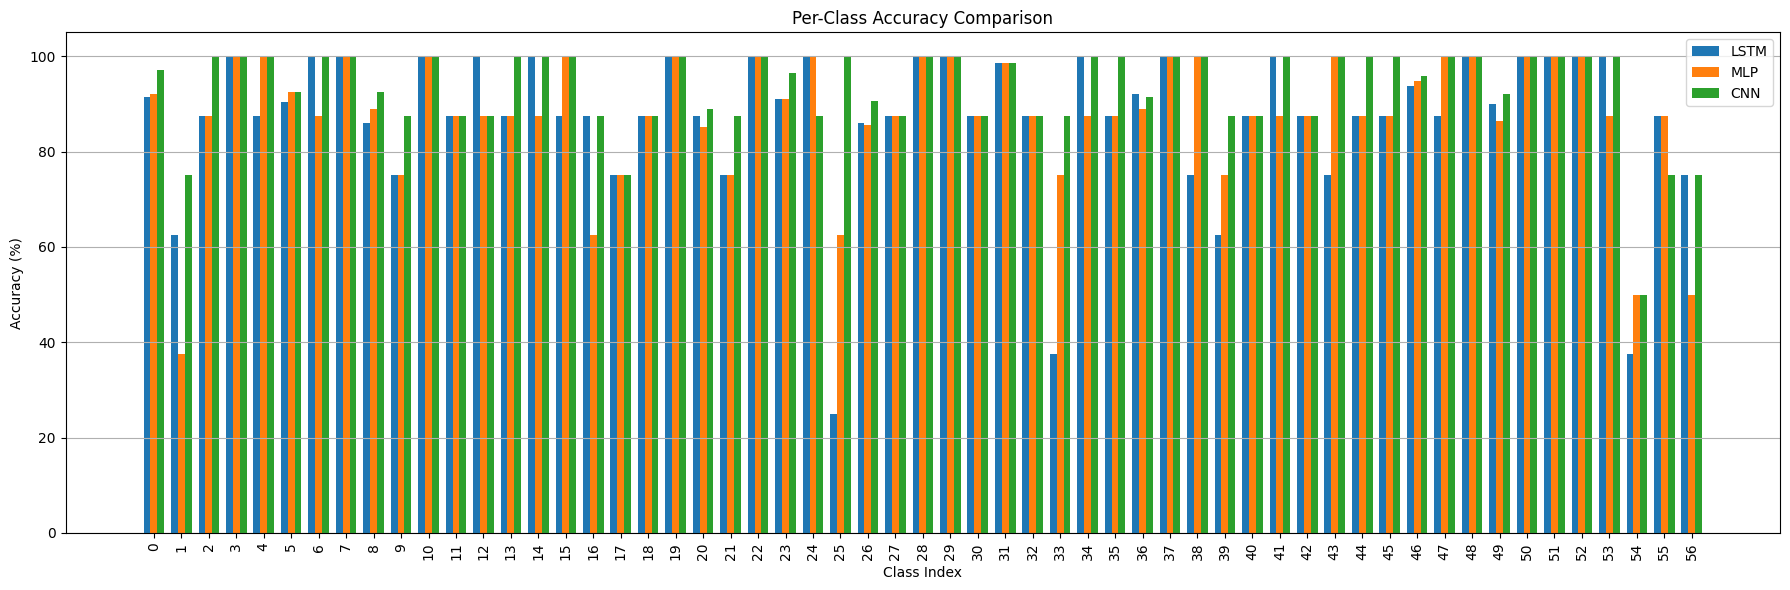

In [11]:
best_model_cnn = find_best_model_name(
    model_type_prefix="CNN",
    model_class=YAMNet1DCNN_Improved,
    test_loader=test_loader,
    metric='avg_class_acc',
    model_dir='models/CNN_Models/TrainingLoop1'  # Specify the directory where models are saved
)
best_model_lstm = find_best_model_name(
    model_type_prefix="LSTM",
    model_class=YAMNetLSTM,
    test_loader=test_loader,
    metric='avg_class_acc',
    model_dir="models/LSTM_Models/TrainingLoop2"  # Specify the directory where models are saved
)
best_model_mlp = find_best_model_name(
    model_type_prefix="MLP",
    model_class=YAMNetMLP,
    test_loader=test_loader,
    metric='avg_class_acc',
    model_dir="models/MLP_Models/TrainingLoop1"  # Specify the directory where models are saved
)
# Step 1: Get per-class accuracies
acc_dict = dict([
    get_class_accuracies("LSTM", YAMNetLSTM, best_model_lstm, test_loader),
    get_class_accuracies("MLP", YAMNetMLP, best_model_mlp, test_loader),
    get_class_accuracies("CNN", YAMNet1DCNN_Improved, best_model_cnn, test_loader),
])

# Step 2: Plot
plot_combined_class_accuracy(acc_dict)

# Apply function
strongest_model_per_class = get_strongest_model_per_class(acc_dict)

# Save to JSON
import json
with open("models/SavedData/strongest_deep_model_per_class.json", "w") as f:
    json.dump(strongest_model_per_class, f, indent=2)

In [12]:
import json
import numpy as np

def compute_combined_model_accuracy(json_path="models/SavedData/strongest_model_per_class.json"):
    with open(json_path, "r") as f:
        data = json.load(f)

    best_accuracies = []

    for class_idx, entry in data.items():
        best_model = entry["best"]
        acc = entry["accuracies"][best_model]
        best_accuracies.append(acc)

    avg_accuracy = np.mean(best_accuracies)
    return avg_accuracy, best_accuracies

def compute_combined_model_accuracy_hybrid_updated(json_path="models/SavedMetrics/best_combined_model_per_class.json"):
    with open(json_path, "r") as f:
        data = json.load(f)

    best_accuracies = []

    for class_idx, entry in data.items():
        acc = entry["accuracy"]
        best_accuracies.append(acc)

    avg_accuracy = np.mean(best_accuracies)
    return avg_accuracy, best_accuracies

def print_worst_classes(all_accs, class_names=None, n=5):
    acc_array = np.array(all_accs)
    worst_indices = acc_array.argsort()[:n]  # Get indices of lowest n accuracies

    print(f"📉 Lowest {n} Classes by Accuracy:")
    for i in worst_indices:
        label = class_names[i] if class_names else f"Class {i}"
        print(f"{label:<20}: {acc_array[i]:.2f}%")


In [ ]:
avg, all_accs = compute_combined_model_accuracy("models/SavedData/strongest_deep_model_per_class.json")

print_worst_classes(all_accs, class_names=None, n=18)

📉 Lowest 18 Classes by Accuracy:
Class 54            : 50.00%
Class 1             : 75.00%
Class 56            : 75.00%
Class 17            : 75.00%
Class 21            : 87.50%
Class 18            : 87.50%
Class 11            : 87.50%
Class 9             : 87.50%
Class 27            : 87.50%
Class 39            : 87.50%
Class 55            : 87.50%
Class 42            : 87.50%
Class 33            : 87.50%
Class 32            : 87.50%
Class 16            : 87.50%
Class 30            : 87.50%
Class 40            : 87.50%
Class 20            : 88.94%


In [ ]:
# TO-DO: Do the 5 models with XGBoost,Logistic Regression, SVM, Random Forest, and Decision Tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import numpy as np

import os
import joblib
import json

def save_model_and_acc_list(model_name, model, acc_list, save_dir="models"):
    os.makedirs(save_dir, exist_ok=True)

    # Save model .pkl
    model_path = os.path.join(save_dir, f"{model_name}.pkl")
    joblib.dump(model, model_path)
    print(f"💾 Saved model to {model_path}")

    # Save or update accuracy list .json
    acc_path = os.path.join(save_dir, "classical_model_per_class_accuracy.json")
    try:
        with open(acc_path, "r") as f:
            acc_data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        acc_data = {}

    acc_data[model_name] = acc_list

    with open(acc_path, "w") as f:
        json.dump(acc_data, f, indent=2)

    print(f"📁 Updated per-class accuracy in {acc_path}")


In [45]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train_np)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_np)
class_weight_dict = dict(zip(classes, class_weights))  # Map class → weight

# Step 2: Build per-sample weights from y_train_np
sample_weights = np.array([class_weight_dict[label] for label in y_train_np])
# Flatten (N, 100, 1024) → (N, 100*1024)
X_train_flat = X_train_np.reshape(X_train_np.shape[0], -1)
X_val_flat = X_val_np.reshape(X_val_np.shape[0], -1)
X_test_flat = X_test_np.reshape(X_test_np.shape[0], -1)

from sklearn.decomposition import PCA

# === Reduce dimensionality ===
pca = PCA(n_components=1024, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)


In [ ]:
import joblib
import numpy as np
import json
import os
from sklearn.metrics import accuracy_score

def save_classical_per_class_accuracies(
    model_files,    # dict: {"ModelName": "/path/to/model.pkl", ...}
    X_test,         # np.array or similar, test features (PCA or flat)
    y_test,         # np.array, test labels
    json_save_path  # str, path to save output json (e.g., "results/classical_per_class.json")
):
    """
    Loads models, computes per-class accuracies, and saves summary as json.
    """
    # Collect predictions from all models
    model_preds = {}
    for model_name, pkl_path in model_files.items():
        model = joblib.load(pkl_path)
        preds = model.predict(X_test)
        model_preds[model_name] = preds

    # Unique classes
    classes = np.unique(y_test)
    n_classes = len(classes)

    # Per-class accuracy dict
    results = {}

    for i, c in enumerate(classes):
        # For this class, compute accuracy for each model
        class_acc = {}
        for model_name, preds in model_preds.items():
            # Accuracy only on samples where true label == c
            idx = (y_test == c)
            acc = accuracy_score(y_test[idx], preds[idx]) * 100 if np.sum(idx) else 0.0
            class_acc[model_name] = round(acc, 2)

        # Determine best model and diff (best - 2nd best, or 0 if tie)
        sorted_models = sorted(class_acc.items(), key=lambda x: -x[1])
        best_model, best_acc = sorted_models[0]
        second_best_acc = sorted_models[1][1] if len(sorted_models) > 1 else best_acc
        diff = round(best_acc - second_best_acc, 2)

        results[str(c)] = {
            "best": best_model,
            "diff": diff,
            "accuracies": class_acc
        }

    # Ensure save directory exists
    os.makedirs(os.path.dirname(json_save_path), exist_ok=True)

    # Save JSON
    with open(json_save_path, "w") as f:
        json.dump(results, f, indent=2)
    print(f"✅ Per-class accuracy saved to: {json_save_path}")

    return results  # Optionally return for in-notebook use


def merge_deep_and_classical_best_models(
    deep_path="models/SavedData/strongest_deep_model_per_class.json",
    classical_path="models/SavedData/strongest_classical_model_per_class.json",
    save_path="models/SavedData/strongest_hybrid_model_per_class.json"
):
    with open(deep_path, "r") as f:
        deep = json.load(f)
    with open(classical_path, "r") as f:
        classical = json.load(f)

    merged = {}

    for class_id in map(str, range(57)):
        # --- Extract best model name and its accuracy from each source ---
        deep_model = deep[class_id]["best"]
        deep_acc = deep[class_id]["accuracies"][deep_model]
        
        classical_model = classical[class_id]["best"]
        classical_acc = classical[class_id]["accuracies"][classical_model]

        # --- Pick whichever is better ---
        if classical_acc > deep_acc:
            merged[class_id] = {
                "best": classical_model,
                "accuracy": classical_acc,
                "source": "classical"
            }
        else:
            merged[class_id] = {
                "best": deep_model,
                "accuracy": deep_acc,
                "source": "deep"
            }

    with open(save_path, "w") as f:
        json.dump(merged, f, indent=2)

    print(f"✅ Merged result saved to {save_path}")
    return merged


In [ ]:
# Suppose your models are in models/
model_files = {
    "LogisticRegression": "models/ClassicalModels/LogisticRegression.pkl",
    "RandomForest": "models/ClassicalModels/RandomForest.pkl",
    "SVM": "models/ClassicalModels/SVM.pkl",
    "XGBoost": "models/ClassicalModels/XGBoost.pkl"
}

# X_test_pca and y_test_np should be your test set in the correct format
save_classical_per_class_accuracies(
    model_files,
    X_test_pca,       # Your PCA-transformed test features
    y_test_np,        # Your test labels
    "models/SavedData/strongest_classical_model_per_class.json"
)


✅ Per-class accuracy saved to: models/SavedData/strongest_classical_model_per_class.json


{'0': {'best': 'LogisticRegression',
  'diff': 0.0,
  'accuracies': {'LogisticRegression': 89.0,
   'RandomForest': 89.0,
   'SVM': 85.5,
   'XGBoost': 87.0}},
 '1': {'best': 'LogisticRegression',
  'diff': 12.5,
  'accuracies': {'LogisticRegression': 75.0,
   'RandomForest': 12.5,
   'SVM': 62.5,
   'XGBoost': 37.5}},
 '2': {'best': 'LogisticRegression',
  'diff': 0.0,
  'accuracies': {'LogisticRegression': 75.0,
   'RandomForest': 62.5,
   'SVM': 75.0,
   'XGBoost': 75.0}},
 '3': {'best': 'LogisticRegression',
  'diff': 12.5,
  'accuracies': {'LogisticRegression': 100.0,
   'RandomForest': 75.0,
   'SVM': 75.0,
   'XGBoost': 87.5}},
 '4': {'best': 'LogisticRegression',
  'diff': 12.5,
  'accuracies': {'LogisticRegression': 75.0,
   'RandomForest': 0.0,
   'SVM': 62.5,
   'XGBoost': 37.5}},
 '5': {'best': 'LogisticRegression',
  'diff': 8.51,
  'accuracies': {'LogisticRegression': 92.55,
   'RandomForest': 74.47,
   'SVM': 84.04,
   'XGBoost': 82.98}},
 '6': {'best': 'LogisticRegressi

In [ ]:
merge_deep_and_classical_best_models()

✅ Merged result saved to models/SavedData/strongest_hybrid_model_per_class.json


{'0': {'best': 'CNN', 'accuracy': 97.0, 'source': 'deep'},
 '1': {'best': 'CNN', 'accuracy': 75.0, 'source': 'deep'},
 '2': {'best': 'CNN', 'accuracy': 100.0, 'source': 'deep'},
 '3': {'best': 'CNN', 'accuracy': 100.0, 'source': 'deep'},
 '4': {'best': 'CNN', 'accuracy': 100.0, 'source': 'deep'},
 '5': {'best': 'CNN', 'accuracy': 92.55, 'source': 'deep'},
 '6': {'best': 'CNN', 'accuracy': 100.0, 'source': 'deep'},
 '7': {'best': 'CNN', 'accuracy': 100.0, 'source': 'deep'},
 '8': {'best': 'CNN', 'accuracy': 92.5, 'source': 'deep'},
 '9': {'best': 'CNN', 'accuracy': 87.5, 'source': 'deep'},
 '10': {'best': 'CNN', 'accuracy': 100.0, 'source': 'deep'},
 '11': {'best': 'CNN', 'accuracy': 87.5, 'source': 'deep'},
 '12': {'best': 'LSTM', 'accuracy': 100.0, 'source': 'deep'},
 '13': {'best': 'CNN', 'accuracy': 100.0, 'source': 'deep'},
 '14': {'best': 'CNN', 'accuracy': 100.0, 'source': 'deep'},
 '15': {'best': 'CNN', 'accuracy': 100.0, 'source': 'deep'},
 '16': {'best': 'CNN', 'accuracy': 87.

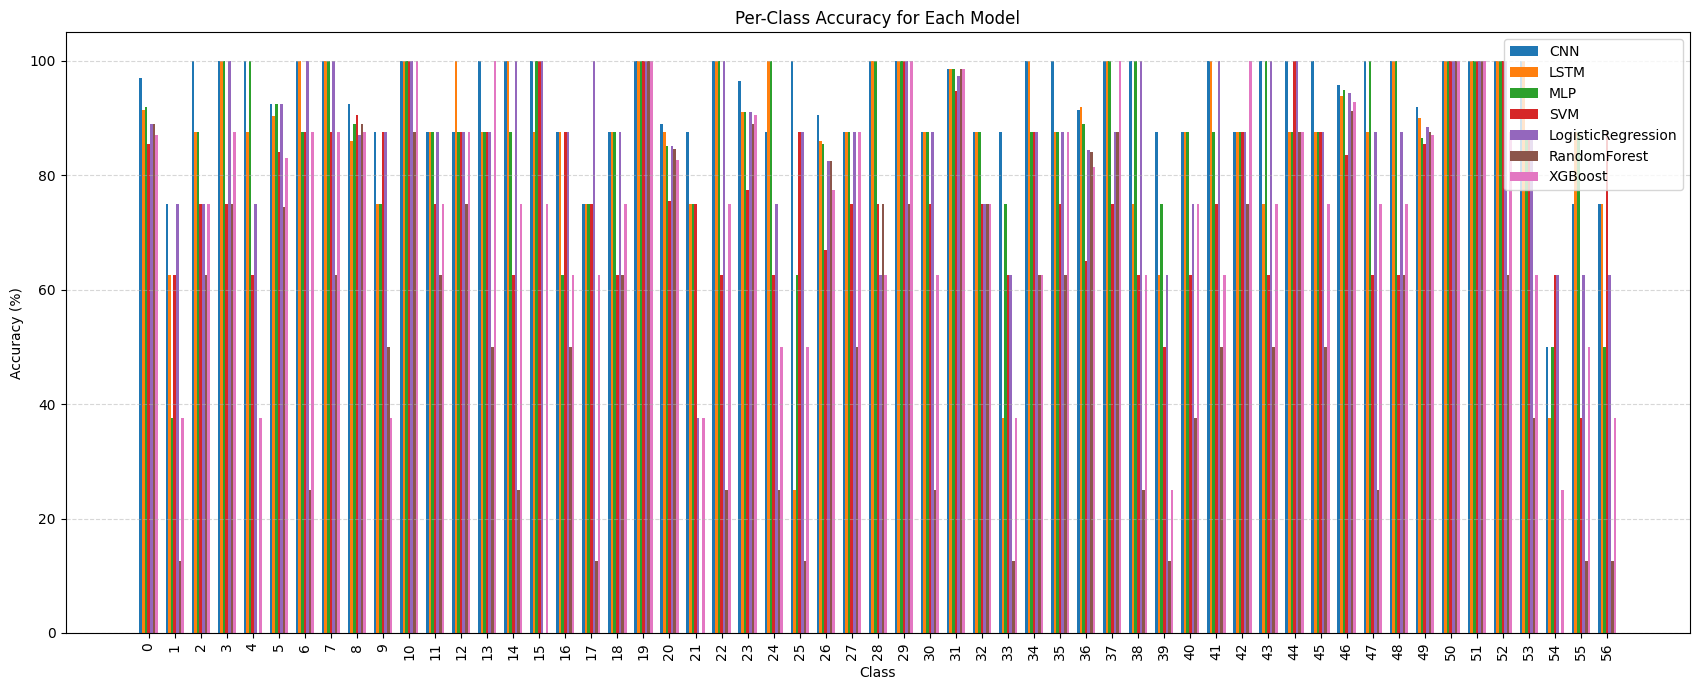

In [25]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load deep models JSON
with open("models/SavedData/strongest_deep_model_per_class.json") as f:
    deep_model_data = json.load(f)
# Load classical models JSON
with open("models/SavedData/strongest_classical_model_per_class.json") as f:
    classical_model_data = json.load(f)

# All models you want to include
all_models = ["CNN", "LSTM", "MLP", "SVM", "LogisticRegression", "RandomForest", "XGBoost"]

# Number of classes (assume keys are "0" to "56")
num_classes = len(deep_model_data)
class_labels = [str(i) for i in range(num_classes)]

# Build (n_models x n_classes) accuracy matrix
accuracies = []
for model in all_models:
    per_class_acc = []
    for class_id in class_labels:
        acc = None
        # Deep models
        if model in ["CNN", "LSTM", "MLP"]:
            acc = deep_model_data[class_id]["accuracies"].get(model, np.nan)
        else:  # Classical models
            acc = classical_model_data[class_id]["accuracies"].get(model, np.nan)
        per_class_acc.append(acc)
    accuracies.append(per_class_acc)

accuracies = np.array(accuracies)  # shape: (n_models, n_classes)

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(max(16, num_classes * 0.3), 7))

bar_width = 0.10
x = np.arange(num_classes)
for i, model in enumerate(all_models):
    ax.bar(x + i * bar_width, accuracies[i], width=bar_width, label=model)

ax.set_xlabel("Class")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Per-Class Accuracy for Each Model")
ax.set_xticks(x + bar_width * (len(all_models)-1) / 2)
ax.set_xticklabels(class_labels, rotation=90)
ax.set_ylim(0, 105)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [33]:
avg, all_accs = compute_combined_model_accuracy_hybrid_updated("models/SavedData/strongest_hybrid_model_per_class.json")
print(f"✅ Combined Hybrid Model — Average Per-Class Accuracy: {avg:.2f}%")
print_worst_classes(all_accs, class_names=None, n=16)

✅ Combined Hybrid Model — Average Per-Class Accuracy: 94.94%
📉 Lowest 16 Classes by Accuracy:
Class 54            : 62.50%
Class 1             : 75.00%
Class 11            : 87.50%
Class 9             : 87.50%
Class 27            : 87.50%
Class 21            : 87.50%
Class 18            : 87.50%
Class 30            : 87.50%
Class 33            : 87.50%
Class 40            : 87.50%
Class 56            : 87.50%
Class 55            : 87.50%
Class 32            : 87.50%
Class 39            : 87.50%
Class 16            : 87.50%
Class 20            : 88.94%


In [43]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import mode

# Paths to your best deep models (update these to match your actual file names)
lstm_path =  best_model_lstm
cnn_path  =  best_model_cnn
mlp_path  = best_model_mlp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
lstm = YAMNetLSTM().to(device)
cnn  = YAMNet1DCNN_Improved().to(device)
mlp  = YAMNetMLP().to(device)
lstm.load_state_dict(torch.load(lstm_path, map_location=device))
cnn.load_state_dict(torch.load(cnn_path, map_location=device))
mlp.load_state_dict(torch.load(mlp_path, map_location=device))
lstm.eval()
cnn.eval()
mlp.eval()

# DataLoader for your test set (update as needed)
# Assuming: test_loader yields (xb, yb) where xb shape is (batch, 100, 1024)
all_lstm_preds, all_cnn_preds, all_mlp_preds = [], [], []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:  # <--- use your actual DataLoader here
        xb = xb.to(device)
        all_labels.extend(yb.cpu().numpy())
        all_lstm_preds.extend(lstm(xb).argmax(1).cpu().numpy())
        all_cnn_preds.extend(cnn(xb).argmax(1).cpu().numpy())
        all_mlp_preds.extend(mlp(xb).argmax(1).cpu().numpy())

all_labels = np.array(all_labels)
deep_preds = np.vstack([all_lstm_preds, all_cnn_preds, all_mlp_preds])  # Shape: [3, n_samples]

# --- Majority voting ---
maj_vote_preds, _ = mode(deep_preds, axis=0, keepdims=False)
maj_vote_preds = maj_vote_preds.ravel()

# --- Metrics ---
overall_acc = accuracy_score(all_labels, maj_vote_preds)
print(f"[Deep Models Only] Majority Voting Ensemble Accuracy: {overall_acc * 100:.2f}%")
print(classification_report(all_labels, maj_vote_preds))

# --- Per-class accuracy ---
unique_classes = np.unique(all_labels)
per_class_acc = {}
for c in unique_classes:
    idx = (all_labels == c)
    if np.sum(idx) > 0:
        per_class_acc[str(c)] = round(100 * accuracy_score(all_labels[idx], maj_vote_preds[idx]), 2)
print("Per-class accuracy (Majority Vote, Deep Models):")
for c, acc in per_class_acc.items():
    print(f"Class {c}: {acc:.2f}%")

# (optional) Save to JSON
import json
out = {
    "overall_accuracy": round(overall_acc * 100, 2),
    "per_class_accuracy": per_class_acc
}
with open("models/SavedData/majority_voting_deep_only.json", "w") as f:
    json.dump(out, f, indent=2)
print("✅ Majority voting (deep only) results saved to models/SavedData/majority_voting_deep_only.json")


[Deep Models Only] Majority Voting Ensemble Accuracy: 92.08%
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       200
           1       0.62      0.62      0.62         8
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00         8
           4       0.80      1.00      0.89         8
           5       0.88      0.93      0.90        94
           6       1.00      1.00      1.00         8
           7       0.89      1.00      0.94         8
           8       0.91      0.92      0.91       200
           9       0.75      0.75      0.75         8
          10       1.00      1.00      1.00         8
          11       1.00      0.88      0.93         8
          12       1.00      0.88      0.93         8
          13       0.89      1.00      0.94         8
          14       0.80      1.00      0.89         8
          15       1.00      1.00      1.00         8
          16       0

In [46]:
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import mode
import json

# List of classical model paths and names
model_files = [
    ("SVM", "models/ClassicalModels/SVM.pkl"),
    ("LogisticRegression", "models/ClassicalModels/LogisticRegression.pkl"),
    ("RandomForest", "models/ClassicalModels/RandomForest.pkl"),
    ("XGBoost", "models/ClassicalModels/XGBoost.pkl")
]

all_preds = []
model_names = []
for name, path in model_files:
    try:
        model = joblib.load(path)
        preds = model.predict(X_test_pca)
        all_preds.append(preds)
        model_names.append(name)
    except Exception as e:
        print(f"Skipping {name}: {e}")

all_preds = np.array(all_preds)  # Shape: [n_models, n_samples]

# --- Majority voting ---
maj_vote_preds, _ = mode(all_preds, axis=0, keepdims=False)
maj_vote_preds = maj_vote_preds.ravel()

# --- Metrics ---
overall_acc = accuracy_score(y_test_np, maj_vote_preds)
print(f"[Classical Models Only] Majority Voting Ensemble Accuracy: {overall_acc * 100:.2f}%")
print(classification_report(y_test_np, maj_vote_preds))

# --- Per-class accuracy ---
unique_classes = np.unique(y_test_np)
per_class_acc = {}
for c in unique_classes:
    idx = (y_test_np == c)
    if np.sum(idx) > 0:
        per_class_acc[str(c)] = round(100 * accuracy_score(y_test_np[idx], maj_vote_preds[idx]), 2)
print("Per-class accuracy (Majority Vote, Classical Models):")
for c, acc in per_class_acc.items():
    print(f"Class {c}: {acc:.2f}%")

# (optional) Save to JSON
out = {
    "overall_accuracy": round(overall_acc * 100, 2),
    "per_class_accuracy": per_class_acc
}
with open("models/SavedData/majority_voting_classical_only.json", "w") as f:
    json.dump(out, f, indent=2)
print("✅ Majority voting (classical only) results saved to models/SavedData/majority_voting_classical_only.json")


[Classical Models Only] Majority Voting Ensemble Accuracy: 86.87%
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       200
           1       0.60      0.75      0.67         8
           2       1.00      0.88      0.93         8
           3       0.89      1.00      0.94         8
           4       0.60      0.75      0.67         8
           5       0.83      0.90      0.86        94
           6       0.80      1.00      0.89         8
           7       1.00      1.00      1.00         8
           8       0.83      0.92      0.87       200
           9       0.86      0.75      0.80         8
          10       1.00      1.00      1.00         8
          11       1.00      0.75      0.86         8
          12       0.88      0.88      0.88         8
          13       1.00      0.88      0.93         8
          14       1.00      0.88      0.93         8
          15       1.00      1.00      1.00         8
          16   